In [178]:
import copy
import json
import os
import re
import glob
import tqdm
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from sklearn.metrics import silhouette_score, pairwise_distances, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

import scipy.stats as st
import scipy.spatial
import scipy.cluster.hierarchy

import requests
import bs4

import umap
# import pymde

# import torch

import igraph as ig
import leidenalg as la

from Bio import SeqIO

import bokeh
from bokeh.plotting import show as show_interactive, output_file, output_notebook
from bokeh.layouts import column, row
from bokeh.models import (
    CustomJS,
    TextInput,
    LassoSelectTool,
    Select,
    MultiSelect,
    ColorBar,
    Legend,
    LegendItem,
    DataTable,
    DateFormatter,
    TableColumn,
    Button,
    HTMLTemplateFormatter,
    FactorRange,
)
from bokeh.events import SelectionGeometry
from bokeh.transform import linear_cmap, jitter

from matplotlib.pyplot import show as show_static

import networkx as nx

import subprocess

from pynndescent import NNDescent

from csv import DictWriter

from datetime import datetime

In [179]:
def shuffle_row(row):
    shuffled_row = row.values.copy()
    np.random.shuffle(shuffled_row)
    return pd.Series(shuffled_row, index=row.index)

def shuffle_rows(df):
    columns_to_shuffle = df.columns[1:]
    df[columns_to_shuffle] = df[columns_to_shuffle].apply(shuffle_row, axis=1)
    return df

In [180]:
def get_geom_mean_expression(expression_df):
    """
    
    Function to take an expression dataframe from the microarrays and collapse it into the means of
    all replicate chips.
    """
    # C2 and S12 got removed during quality control
    x = [
        'Ll', 
        'Lm', 
        'Lh', 
        'S0', 
        'S3', 
        'S6', 
        'S9', 
        # 'S12', 
        'S15', 
        'S24', 
        'C0', 
        # 'C2', 
        'C4', 
        'C6', 
        'C8', 
        'C10', 
        'C12', 
        'C14', 
        'C16', 
        'C18']
    
    # cols = expression_df.columns[1:]
    # x = [c for c in x if c in cols]
    
    condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
    for c in list(expression_df.columns)[1:]:
        
        cond = c.split('_')[0]
        if cond in condition_expr_dict.keys():
            expr_list = condition_expr_dict.get(cond, [])

            # Need to avoid true zeros
            expr_list.append(expression_df[c].values)
            condition_expr_dict[cond] = expr_list
        
    condition_mean_dict = {c: (st.mstats.gmean(np.array(condition_expr_dict[c]) + 1, 0) - 1) for c in condition_expr_dict.keys() if c in x}
    
    mean_expr_df = pd.DataFrame(condition_mean_dict)
    mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
    cols = list(mean_expr_df.columns)
    reorder = cols[-1:] + cols[:-1]
    mean_expr_df = mean_expr_df[reorder]
    
    return mean_expr_df

def normalizer(array):
    """
    Normalizes the values of an array to range from zero to one
    """
    
    a = np.array(array)
    
    normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
    
    return normalized

def normalize_expression_per_gene(expression_df):
    """
    Function to normalize all gene expression to range from zero to one.
    """
    if 'TTHERM_ID' in expression_df.columns:
        ttids = expression_df['TTHERM_ID'].values
        data = expression_df[list(expression_df.columns)[1:]]
        
        norm_expression_df = data.apply(lambda row: normalizer(row), axis=1)
        norm_expression_df['TTHERM_ID'] = ttids
        
        columns = norm_expression_df.columns.tolist()
        
        rearrangment = columns[-1:] + columns[:-1]
        
        norm_expression_df = norm_expression_df[rearrangment]
        
    else:
        norm_expression_df = expression_df.apply(lambda row: normalizer(row), axis=1)
    
    return norm_expression_df

In [181]:
def compute_pairwise_distance_matrix(data_df, metric, n_jobs=-1, p_minkowski=1):

    if metric == 'minkowski':
        pair_dists = pairwise_distances(data_df, metric=metric, n_jobs=n_jobs, p=p_minkowski)
    else:
        pair_dists = pairwise_distances(data_df, metric=metric, n_jobs=n_jobs)
    
    return pair_dists

In [182]:
def compute_nns(data_df, nn, metric, random_state=42, n_jobs=-1, p_minkowski=1):
    
    # num_neighbors = NearestNeighbors(n_neighbors=nn, metric='precomputed', n_jobs=-1).fit(manhattan_distance_matrix)
    # nn_dists, nn_idxs = num_neighbors.kneighbors(return_distance=True)

    n_trees = min(64, 5 + int(round((data_df.shape[0]) ** 0.5 / 20.0)))
    n_iters = max(5, int(round(np.log2(data_df.shape[0]))))

    if metric == 'minkowski':
        knn_search_index = NNDescent(
                data_df,
                n_neighbors=nn,
                metric=metric,
                metric_kwds={'p': p_minkowski},
                random_state=random_state,
                n_trees=n_trees,
                n_iters=n_iters,
                max_candidates=60,
                # low_memory=low_memory,
                n_jobs=n_jobs,
                verbose=False,
                compressed=False,
            )
    else:
        knn_search_index = NNDescent(
                    data_df,
                    n_neighbors=nn,
                    metric=metric,
                    # metric_kwds=metric_kwds,
                    random_state=random_state,
                    n_trees=n_trees,
                    n_iters=n_iters,
                    max_candidates=60,
                    # low_memory=low_memory,
                    n_jobs=n_jobs,
                    verbose=False,
                    compressed=False,
                )
    nn_idxs, nn_dists = knn_search_index.neighbor_graph

    return nn_idxs, nn_dists

In [183]:
def compute_umap_graph(data_df, nn, metric, nn_idxs, nn_dists):
    
    result, sigmas, rhos, dists = umap.umap_.fuzzy_simplicial_set(data_df, nn, 42, metric, knn_indices=nn_idxs, knn_dists=nn_dists, return_dists=True)

    sources, targets = result.nonzero()
    edge_list = zip(sources, targets)
    weights = result.data

    g = ig.Graph(edges=edge_list, edge_attrs={'weight': weights})
    
    return g

In [184]:
def compute_leiden_partition(graph, resolution_parameter, random_state=42):
        
        partition = la.find_partition(graph, la.CPMVertexPartition, resolution_parameter = resolution_parameter, seed=random_state, weights='weight')
        # partition = la.find_partition(g, la.ModularityVertexPartition, seed=42, weights='weight')

        leiden_modules = np.array(partition.membership)

        return leiden_modules

In [185]:
def compute_communities(parition, idx_labels):
    communities = {}

    for idx, membership in enumerate(parition):
        if membership not in communities:
            communities[membership] = []
        communities[membership].append(idx_labels[idx])

    return communities.values()

In [186]:
def compute_silhouette_score(distance_matrix, parition):
    return silhouette_score(distance_matrix, parition, metric='precomputed')

In [187]:
def compute_modularity(graph, communities):
    nx_g = nx.Graph(graph.get_edgelist())
    return nx.community.quality.modularity(nx_g, communities, weight='weight')

In [188]:
def format_parition_for_enrichment(df, parition):
    edf = pd.DataFrame.from_dict({'TTHERM_ID': []})
    edf['TTHERM_ID'] = df['TTHERM_ID'].values
    edf[f'leiden_label_full'] = parition
    return edf

In [189]:
def remove_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)

In [190]:
def compute_enrichment(df, parition):
    edf = format_parition_for_enrichment(df, parition)

    temp_scan_file = './temp_scan_partition.csv'

    temp_enrich_file = './temp_scan_enrich.csv'

    edf.to_csv(temp_scan_file, index=False)

    subprocess.run(['python3', './fast_enrichment_analysis.py', temp_scan_file, temp_enrich_file])

    cedf = pd.read_csv(temp_enrich_file)
    
    remove_file(temp_scan_file)

    remove_file(temp_enrich_file)

    return cedf

In [191]:
def compute_num_clusters(parition, communities=None):
    if communities is None:
        return len(set(parition))
    
    if len(set(parition)) != len(communities):
        raise ValueError(f'The number of clusters/modules ({len(set(parition))}) in the parition != the number of communities ({len(communities)}).')
    
    return len(set(parition))

In [192]:
def compute_num_enriched_clusters(cedf):
    return len(set(cedf['module'].values))

In [193]:
def compute_num_enriched_cluster_genes(edf, parition):
    total_num_genes = 0

    for m in set(edf['module'].values):
        num_genes = np.count_nonzero(parition == int(m))
        total_num_genes += num_genes
    
    return total_num_genes
    

In [194]:
def write_to_csv(csv_file_path, data_item, header):
    # Check if the CSV file exists and write header if it doesn't
    if not os.path.isfile(csv_file_path):
        with open(csv_file_path, 'w', newline='') as file:
            writer = DictWriter(file, fieldnames=header)
            writer.writeheader()

    with open(csv_file_path, 'a', newline='') as file:
        writer = DictWriter(file, fieldnames=header)
        writer.writerow(data_item)

# CLUSTER START

In [195]:
shuffle = False
num_iterations = 1
full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})

In [196]:
full_filtered_df.head()

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_000000042,6.928782,7.264201,6.934214,6.732989,6.970612,7.150978,6.126826,6.868968,6.641119,...,6.450318,8.049750,7.788162,7.052154,6.517742,6.918501,6.048861,7.041619,6.757932,5.817246
1,TTHERM_000000045,9.633489,9.977124,10.027529,9.720665,9.605762,10.225542,10.279608,10.459966,10.693337,...,11.130466,11.207738,11.009172,10.615417,11.038938,11.009222,10.216348,11.099187,11.172276,10.561021
2,TTHERM_00000010,5.066343,4.767264,5.010981,6.139047,4.619361,4.751761,5.818550,5.342529,5.483750,...,6.314438,7.423571,7.507645,7.417087,7.147801,7.747930,7.093641,7.672685,7.511290,6.890117
3,TTHERM_00000020,4.696881,4.638401,4.956299,6.942556,5.101252,4.730307,8.457690,4.526411,4.908300,...,5.250233,4.974993,5.747498,5.252167,5.210531,7.083187,5.252222,5.037613,5.495281,5.013987
4,TTHERM_00000030,4.654278,4.537105,4.928739,5.063991,4.584168,4.911880,5.935311,4.519470,4.757861,...,4.651688,4.920573,4.636333,4.883712,4.779395,4.744335,4.513140,4.838428,4.961475,4.653340


In [197]:
# np.random.seed(42)
# X, _ = make_blobs(n_samples=10000, n_features=30, centers=350, cluster_std=1.0, random_state=42)  # Use only 2 features
# # Convert X to a DataFrame
# columns = ['feature' + str(i) for i in range(X.shape[1])]
# df = pd.DataFrame(X, columns=columns)
# raw_data = df.values

In [198]:
dimensions = 47

sampler = st.qmc.LatinHypercube(d=dimensions)
# sampler = st.qmc.Sobol(d=dimensions)
hypercube_sample = sampler.random(n=20326)

hypercube_sample.shape


(20326, 47)

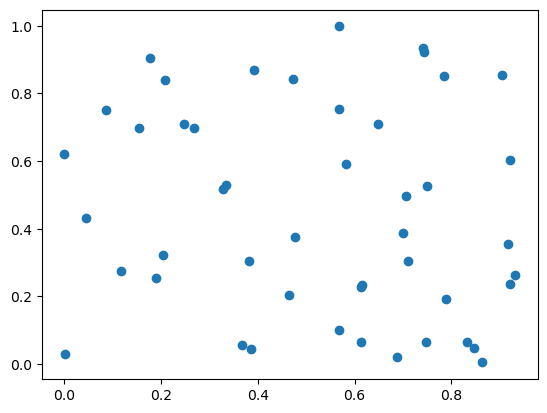

In [199]:
plt.scatter(hypercube_sample[1234], hypercube_sample[20000])

In [200]:
def get_cpu_cores():
    # If you're using Linux or macOS
    if os.name == 'posix':
        return os.cpu_count()

    # If you're using Windows
    elif os.name == 'nt':
        return multiprocessing.cpu_count()

    # If the operating system is not recognized
    else:
        return "Unable to determine the number of CPU cores."

# Get and print the number of CPU cores
num_cores = get_cpu_cores()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 10


In [201]:
def floor_half_to_even(number):
    return number // 4 * 2

num_workers = floor_half_to_even(num_cores)
num_workers

4

In [202]:
st.qmc.discrepancy(hypercube_sample, workers=num_workers)

1.752187502913408

In [203]:
curr_datetime = str(datetime.now())

In [204]:
metric = 'minkowski'
# p_minkowski = 0.5
n_jobs = -1
random_state = 42

In [205]:
nn = 12

In [206]:
rp = 0.0950

In [207]:
# num_iterations = 100
# shuffle = True

In [208]:
# for iteration in tqdm.tqdm(range(num_iterations)):
for p_minkowski in np.arange(0.1, 1.1, 0.1):
    
    if shuffle:
        full_filtered_df = shuffle_rows(full_filtered_df)
        
    full_filtered_norm_df = normalize_expression_per_gene(full_filtered_df)
    
    raw_data = full_filtered_norm_df[list(full_filtered_norm_df.columns)[1:]].values
    # raw_data = pd.DataFrame(hypercube_sample)

    idx_labels = list(range(raw_data.shape[0]))


    distance_matrix = compute_pairwise_distance_matrix(raw_data, metric, n_jobs, p_minkowski)

    nn_idxs, nn_dists = compute_nns(raw_data, nn, metric, random_state, n_jobs, p_minkowski)

    nn_graph = compute_umap_graph(raw_data, nn, metric, nn_idxs, nn_dists)

    parition = compute_leiden_partition(nn_graph, rp, random_state)

    communities = compute_communities(parition, idx_labels)

    sil_score = compute_silhouette_score(distance_matrix, parition)

    modularity = compute_modularity(nn_graph, communities)

    enrichment_df = compute_enrichment(full_filtered_norm_df, parition)

    num_clusters = compute_num_clusters(parition, communities)

    num_enriched_clusters = compute_num_enriched_clusters(enrichment_df)

    num_enriched_cluster_genes = compute_num_enriched_cluster_genes(enrichment_df, parition)

    cluster_stats = {
        'shuffled': shuffle,
        'dimensionality': 'baseline',
        'graph': 'umap_fuzzy_simplicial_set',
        'nns': nn,
        'clustering': 'leiden_cpm',
        'parameter': rp,
        'metric': f'{metric}_{p_minkowski}' if metric == 'minkowski' else metric,
        'nclusters': num_clusters,
        'silhouette_score': sil_score,
        'modularity': modularity,
        'nenriched_clusters': num_enriched_clusters,
        'nenriched_cluster_genes': num_enriched_cluster_genes,
        'datetime': curr_datetime
    }

    write_to_csv('./scan_stats.csv', cluster_stats, list(cluster_stats.keys()))

100%|██████████| 1905/1905 [00:23<00:00, 81.29it/s] 


In [209]:
sil_score

0.035347023885248983

In [210]:
modularity

0.2944061004414327

In [211]:
num_clusters

1905

In [212]:
num_enriched_clusters

316

In [213]:
num_enriched_cluster_genes

4058

In [214]:
def get_gene_module_assignments(all_gene_labels, gene_list, parition):
    gene_module_assignments = {}

    for gene in gene_list:
        if gene not in all_gene_labels:
            raise ValueError(f'The gene {gene} is not in the list of all gene labels.')
        gene_idx = all_gene_labels.index(gene)
        module_num = parition[gene_idx]
        if module_num not in gene_module_assignments:
            gene_module_assignments[module_num] = []
        gene_module_assignments[module_num].append(gene)

    return gene_module_assignments

In [215]:
gene_list_1 = ["TTHERM_01055600", "TTHERM_01002870", "TTHERM_01002860", "TTHERM_00630470", "TTHERM_00624730", "TTHERM_00624720", "TTHERM_00527180", "TTHERM_00522600", "TTHERM_00378890", "TTHERM_00335830", "TTHERM_00221120"]

In [216]:
gene_list_2 = ["TTHERM_00420610", "TTHERM_00410210", "TTHERM_00313130", "TTHERM_00467390"]
#                                                                       MAYBE

In [217]:
gene_list_3 = ["TTHERM_01107420", "TTHERM_01004990", "TTHERM_00985020", "TTHERM_00899470", "TTHERM_00865150", "TTHERM_00858130", "TTHERM_00849480", "TTHERM_00829340", "TTHERM_00780750", "TTHERM_00716180", "TTHERM_00704030", "TTHERM_00691170", "TTHERM_00684590", "TTHERM_00670190", "TTHERM_00571880", "TTHERM_00561799", "TTHERM_00529890", "TTHERM_00526250", "TTHERM_00469140", "TTHERM_00455600", "TTHERM_00439330", "TTHERM_00439030", "TTHERM_00424700", "TTHERM_00316660", "TTHERM_00312120", "TTHERM_00301770", "TTHERM_00297130", "TTHERM_00292160", "TTHERM_00243710", "TTHERM_00113120", "TTHERM_000711791", "TTHERM_00069420", "TTHERM_00048890", "TTHERM_000463439", "TTHERM_000439109", "TTHERM_00037290", "TTHERM_000248319", "TTHERM_000086999", "TTHERM_01079170", "TTHERM_01005150", "TTHERM_00865050", "TTHERM_00773520", "TTHERM_00729230", "TTHERM_00704040", "TTHERM_00672040", "TTHERM_00667000", "TTHERM_00648920", "TTHERM_00614820", "TTHERM_00576890", "TTHERM_00572090", "TTHERM_00483610", "TTHERM_00446570", "TTHERM_00441870", "TTHERM_00219420", "TTHERM_00194810", "TTHERM_00161750", "TTHERM_00142290", "TTHERM_001000210", "TTHERM_00083540", "TTHERM_00058860", "TTHERM_00048980", "TTHERM_00046130", "TTHERM_000420919", "TTHERM_000383629", "TTHERM_00013120", "TTHERM_00011190", "TTHERM_01245640", "TTHERM_01197090", "TTHERM_01195950", "TTHERM_01016190", "TTHERM_00790790", "TTHERM_00585320", "TTHERM_00568050", "TTHERM_00554270", "TTHERM_00498190", "TTHERM_00487030", "TTHERM_00448570", "TTHERM_00277550", "TTHERM_00242370", "TTHERM_00143660", "TTHERM_00105150", "TTHERM_00092850", "TTHERM_000011759"]

In [218]:
get_gene_module_assignments(list(full_filtered_norm_df['TTHERM_ID'].values), gene_list_1, list(parition))

{821: ['TTHERM_01055600',
  'TTHERM_01002870',
  'TTHERM_01002860',
  'TTHERM_00630470',
  'TTHERM_00624730',
  'TTHERM_00624720',
  'TTHERM_00527180',
  'TTHERM_00522600',
  'TTHERM_00378890',
  'TTHERM_00335830',
  'TTHERM_00221120']}

In [219]:
get_gene_module_assignments(list(full_filtered_norm_df['TTHERM_ID'].values), gene_list_2, list(parition))

{411: ['TTHERM_00420610', 'TTHERM_00313130'],
 118: ['TTHERM_00410210'],
 1798: ['TTHERM_00467390']}

In [220]:
get_gene_module_assignments(list(full_filtered_norm_df['TTHERM_ID'].values), gene_list_3, list(parition))

{143: ['TTHERM_01107420',
  'TTHERM_01004990',
  'TTHERM_00858130',
  'TTHERM_00780750',
  'TTHERM_00691170',
  'TTHERM_00561799',
  'TTHERM_00439330',
  'TTHERM_00439030',
  'TTHERM_00316660',
  'TTHERM_00301770',
  'TTHERM_00243710',
  'TTHERM_000711791',
  'TTHERM_000248319',
  'TTHERM_01079170',
  'TTHERM_00672040',
  'TTHERM_00013120'],
 1023: ['TTHERM_00985020',
  'TTHERM_00526250',
  'TTHERM_00312120',
  'TTHERM_00292160',
  'TTHERM_00113120'],
 966: ['TTHERM_00899470'],
 220: ['TTHERM_00865150',
  'TTHERM_00684590',
  'TTHERM_00571880',
  'TTHERM_00424700',
  'TTHERM_00069420'],
 168: ['TTHERM_00849480', 'TTHERM_00829340', 'TTHERM_00716180'],
 203: ['TTHERM_00704030',
  'TTHERM_00529890',
  'TTHERM_00469140',
  'TTHERM_00455600',
  'TTHERM_00037290'],
 356: ['TTHERM_00670190'],
 362: ['TTHERM_00297130'],
 367: ['TTHERM_00048890', 'TTHERM_000086999'],
 863: ['TTHERM_000463439'],
 1815: ['TTHERM_000439109'],
 531: ['TTHERM_01005150',
  'TTHERM_00704040',
  'TTHERM_00614820',
  'T

In [221]:
import numpy as np

def fractional_distance(x, y, p):
    """
    Calculate fractional distance between two vectors x and y.

    Parameters:
    - x, y: Input vectors (lists, arrays, etc.).
    - p: Fractional exponent.

    Returns:
    - Fractional distance.
    """
    if len(x) != len(y):
        raise ValueError("Input vectors must have the same length")

    distance = np.power(np.sum(np.abs(np.array(x) - np.array(y)) ** p), 1/p)
    return distance

# Example usage:
vector1 = [1, 2, 3]
vector2 = [4, 5, 6]
fractional_exponent = 0.5

result = fractional_distance(vector1, vector2, fractional_exponent)
print(f"The fractional distance between vector1 and vector2 is: {result}")


The fractional distance between vector1 and vector2 is: 27.0
